In [ ]:
!pip install requests
!pip install datetime
!pip install pyyaml h5py

In [ ]:
import pandas as pd
import numpy as np
import requests
import datetime
import time
import matplotlib.pyplot as plt
from pathlib import Path # import Path from pathlib
from geopy.distance import geodesic
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="TravelIn")

In [ ]:
def api_get_coordinate(fetch_id):

    api_url = "https://backend-service1-473303426237.asia-southeast2.run.app/users"

    try:
        # Mengambil data dari API
        response = requests.get(api_url)
        response.raise_for_status()
        users_data = response.json()

        latest_coordinate = None

        # Mencari data untuk user yang diminta
        for user in users_data:
            user_id = user.get("userId")
            latitude = user.get("latitude")
            longitude = user.get("longitude")
            timestamp = user.get("timestamp")

            if user_id != fetch_id:
                continue

            if latitude is None or longitude is None:
                print(f"Error: Tidak ada koordinat untuk user ID {user_id}.")   #Pesan Error
                return None

            if isinstance(timestamp, dict):
                timestamp = timestamp.get('$date')

            if timestamp is not None:
                # Mengonversi timestamp ke objek datetime
                timestamp_dt = datetime.datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S%z")

                # Simpan data jika ditemukan
                latest_coordinate = {
                    'user_id': user_id,
                    'latitude': latitude,
                    'longitude': longitude,
                    'timestamp': timestamp_dt
                }
            else:
                print(f"Warning: Timestamp hilang untuk user ID {user_id}. Skipping this user.") #Pesan Error

        # Menampilkan hasil
        if latest_coordinate:
            return latest_coordinate  # Mengembalikan data koordinat
        else:
            print(f"Tidak ada data ditemukan untuk user ID: {fetch_id}") #Pesan Error
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from API: {e}") #Pesan Error
        return None
    except ValueError as e:
        print(f"Error parsing JSON: {e}") #Pesan Error
        return None

In [ ]:
def get_location_details(lat, longi):
    try:
        location = geolocator.reverse((lat, longi), exactly_one=True, language='in')
        if location and 'address' in location.raw:
            address = location.raw['address']
            city = address.get('city') or address.get('town') or address.get('village')
            state = address.get('state') or address.get('region')
            country = address.get('country')

            return city, state, country
        else:
            print("Error. Cannot fetch location details from coordinates!") #Pesan Error
            return None, None, None
    except Exception as e:
        print(f"An unexpected error occurred while fetching location details: {e}") #Pesan Error
        return None, None, None

In [ ]:
def gps_locator(user_id):
    try:
        coordinates = api_get_coordinate(user_id)

        if coordinates is not None:
            lat = coordinates['latitude']
            longi = coordinates['longitude']
            print(f"User ID : {user_id}\n")
            print("---Location Details---\n")
            print(f"Latitude: {lat}")
            print(f"Longitude: {longi}")

            #return user_id, lat, longi

            # Mendapatkan detail lokasi
            city, state, country = get_location_details(lat, longi)
            if city and state and country:
                print(f"City: {city}")
                print(f"State/Region: {state}")
                print(f"Country: {country}")

                #return city, state, country
            else:
                print("Failed to retrieve location details.") #Pesan Error
        else:
            print(f"Could not retrieve location for user {user_id}") #Pesan Error
            return None, None  # Return None for both if location not found
    except Exception as e:
        print(f"An error occurred: {e}") #Pesan Error
        return None, None  # Return None for both in case of an error

In [ ]:
#Contoh buat MD
user_id_to_locate = "c72b39e9-12c2-4d75-bafb-00e0c6d9a70f"
gps_locator(user_id_to_locate)

User ID : c72b39e9-12c2-4d75-bafb-00e0c6d9a70f

---Location Details---

Latitude: -6.1809267004964505
Longitude: 106.83258922925201
City: Daerah Khusus ibukota Jakarta
State/Region: Jawa
Country: Indonesia


In [ ]:
url = "https://backend-service1-473303426237.asia-southeast2.run.app/places"

response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

dataTempat = response.json()
df = pd.DataFrame(dataTempat)
print(df.head())

    id place_id                place_name  \
0  165      165        Semarang Chinatown   
1  068       68             Bendung Lepen   
2  004        4  Atlantis Water Adventure   
3  095       95             Heha Sky View   
4  085       85                 Candi Ijo   

                                         description       category  \
0  "Terbentuknya Pecinan Semarang tak terlepas da...         budaya   
1  "Bendung Lepen sendiri dulunya merupakan salur...  taman-hiburan   
2  "Atlantis Water Adventure atau dikenal dengan ...  taman-hiburan   
3  "HeHa Sky View adalah salah satu tempat wisata...  taman-hiburan   
4  "Candi Ijo (bahasa Jawa: ꦕꦤ꧀ꦝꦶ​ꦆꦗꦺꦴ, translit....         budaya   

         city  price rating       lat        long  \
0    Semarang  30000    4.5 -6.974992  110.424954   
1  Yogyakarta      0    4.6 -7.831667  110.394512   
2     Jakarta  94000    4.5 -6.124190  106.839134   
3  Yogyakarta  15000    4.4 -7.849614  110.478324   
4  Yogyakarta   5000    4.6 -7.783828

In [ ]:
df['id'] = df['id'].astype('int64')
df['place_id'] = df['place_id'].astype('int64')
df['rating'] = df['rating'].astype('float64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           204 non-null    int64  
 1   place_id     204 non-null    int64  
 2   place_name   204 non-null    object 
 3   description  204 non-null    object 
 4   category     204 non-null    object 
 5   city         204 non-null    object 
 6   price        204 non-null    int64  
 7   rating       204 non-null    float64
 8   lat          204 non-null    float64
 9   long         204 non-null    float64
 10  photo_url    204 non-null    object 
dtypes: float64(3), int64(3), object(5)
memory usage: 17.7+ KB


In [ ]:
import pickle
def reccomended_destination(user_id):
    # Ambil data tempat dari API
    url = "https://backend-service1-473303426237.asia-southeast2.run.app/places"
    response = requests.get(url)
    response.raise_for_status()
    dataTempat = response.json()
    df_places = pd.DataFrame(dataTempat)

    df_places['id'] = df_places['id'].astype('int64')
    df_places['place_id'] = df_places['place_id'].astype('int64')
    df_places['rating'] = df_places['rating'].astype('float64')

    # Ambil Koordinat Pengguna
    coordinates = api_get_coordinate(user_id)
    if coordinates is None:
        print("Could not retrieve user coordinates.")
        return None

    user_lat = coordinates['latitude']
    user_long = coordinates['longitude']

    # Hitung Jarak Menggunakan Haversine (atau geopy)
    df_places['distance'] = df_places.apply(
        lambda row: geodesic((user_lat, user_long), (row['lat'], row['long'])).km, axis=1)

    # Persiapan Data untuk Neural Network
    user_lati = np.repeat(user_lat, len(df_places))
    user_longi = np.repeat(user_long, len(df_places))
    dest_lati = df_places['lat'].values
    dest_longi = df_places['long'].values
    rating = df_places['rating'].values
    price = df_places['price'].values
    distances = df_places['distance'].values
    df_places['delta_lat'] = df_places['lat'] - user_lat
    df_places['delta_long'] = df_places['long'] - user_long

    X = df_places[['delta_lat', 'delta_long', 'rating', 'price']]
    y = distances
    scaler = MinMaxScaler()

    y = scaler.fit_transform(y.reshape(-1, 1))
    y = y.flatten()

    # Split data menjadi training dan testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Data Normalisasi
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Melatih Model
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * (0.1 ** (epoch // 30)))

    # Struktur Model yang Lebih Dalam
    model = keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='linear')
    ])

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

    history = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[early_stopping, lr_schedule])

    # Evaluasi Model
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Model MAE: {mae:.2f} km")

    # Prediksi jarak untuk 5 tempat terdekat
    predictions = model.predict(X_test)
    df_predictions = pd.DataFrame({
        'Actual Distance': y_test,
        'Predicted Distance': predictions.flatten()
    })

    # Menampilkan 5 tempat terdekat dari hasil prediksi
    nearest_places = df_places.nsmallest(5, 'distance')
    print("5 Tempat terdekat:")
    print(nearest_places[['place_id', 'place_name', 'distance']])

    model.save('travelin.h5')
    with open('travelin.pkl', 'wb') as f:
        pickle.dump(model, f)

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TFLite model
    with open('travelin.tflite', 'wb') as f:
        f.write(tflite_model)

    return nearest_places, history, df_predictions

In [ ]:
user_id = "c72b39e9-12c2-4d75-bafb-00e0c6d9a70f"
nearest_place, history, df_predictions = reccomended_destination(user_id)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - loss: 0.2544 - mae: 0.4061 - val_loss: 0.1578 - val_mae: 0.3107 - learning_rate: 1.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1628 - mae: 0.3253 - val_loss: 0.1217 - val_mae: 0.2689 - learning_rate: 1.0000e-04
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1294 - mae: 0.2864 - val_loss: 0.0943 - val_mae: 0.2511 - learning_rate: 1.0000e-04
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1086 - mae: 0.2803 - val_loss: 0.0737 - val_mae: 0.2321 - learning_rate: 1.0000e-04
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0903 - mae: 0.2603 - val_loss: 0.0573 - val_mae: 0.2140 - learning_rate: 1.0000e-04
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0597 - mae: 0.2149 - val_loss: 0.0446 - val_mae: 0.1934 - learning_rate: 1.0000e-04
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0535 - mae: 0.2041 - val_loss: 0.0349 - val_mae: 0.1713 - learning_rate: 1.

5 Tempat terdekat:
     place_id                   place_name  distance
41         30        Perpustakaan Nasional  0.634084
167        24  Museum Kebangkitan Nasional  0.672501
15          1             Monumen Nasional  0.858255
137         6                   Pasar Seni  1.118724
90         20          Jakarta Planetarium  1.227059
Saved artifact at '/tmp/tmpiiudwcf0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134787802406176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134787800004240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134787800023984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134787800024160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134787800027680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134787800025568: TensorSpec(shape=(

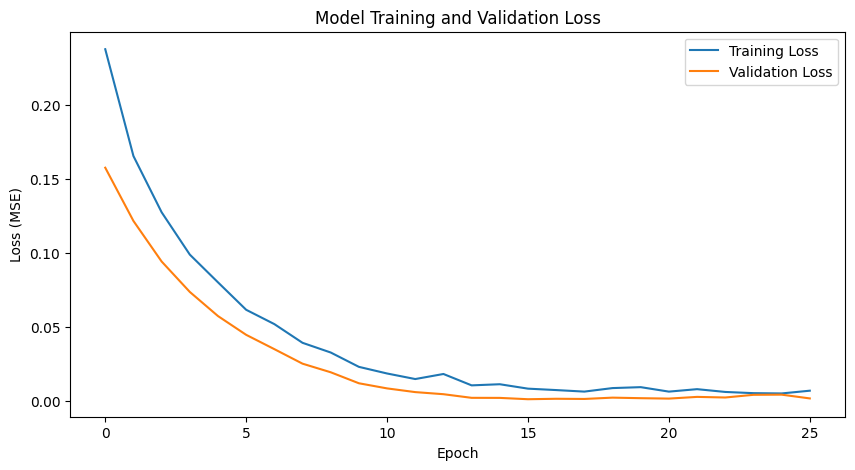

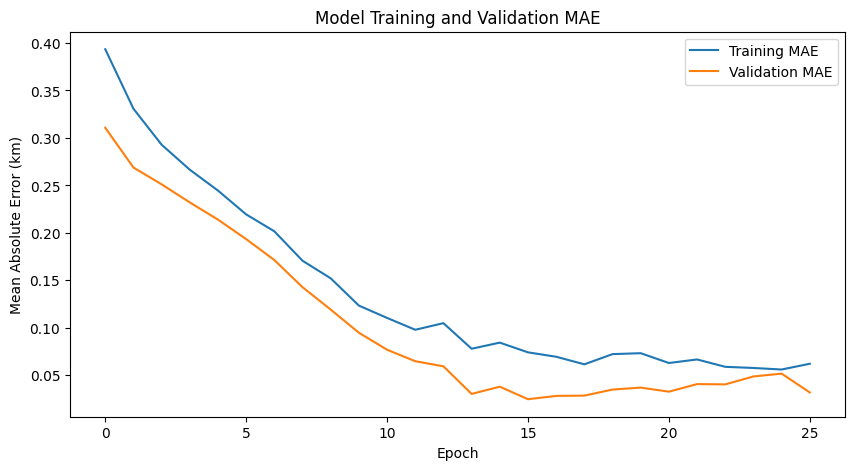

In [ ]:

# Plotting the training and validation loss
if history is not None:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training and Validation Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # If you want to analyze additional metrics (like MAE if added during model.compile)
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model Training and Validation MAE')
        plt.ylabel('Mean Absolute Error (km)')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.show()
else:
    print("Model training failed or history is not available.")

In [ ]:

# Contoh nilai y_test dan y_pred
y_test = df_predictions['Actual Distance'].values
y_pred = df_predictions['Predicted Distance'].values

# Menghapus nilai nol atau negatif dari y_test dan y_pred
y_test_cleaned = y_test[y_test > 0]  # Hapus nilai nol atau negatif
y_pred_cleaned = y_pred[:len(y_test_cleaned)]


# Hapus nilai yang mendekati nol (misalnya lebih kecil dari 0.01)
valid_indices = y_test > 0.01
y_test_valid = y_test[valid_indices]
y_pred_valid = y_pred[valid_indices]

# Hitung MAPE kembali setelah validasi
mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100
accuracy = 100 - mape
print(f"MAPE: {mape:.2f}%")
print(f"Akurasi Model: {accuracy:.2f}%")
mse = np.mean((y_test - y_pred) ** 2)
mae = np.mean(np.abs(y_test - y_pred))
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MAPE: 7.02%
Akurasi Model: 92.98%
MSE: 0.0009286067530530312
MAE: 0.027169595089324688
